In [1]:
from itertools import chain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.ma import masked_where

In [3]:
train_data = pd.read_csv('../data/split/train_data.csv')
test_data = pd.read_csv('../data/split/test_data.csv')

## timestamp missing values

Add missing values to train dataframe. These values are empty.

In [4]:
timestamps = train_data['timestamp']

In [5]:
delay = 30      # s
threshold = 30  # s

t = int(timestamps[0])
c = 0
indexes = []
# print(len(timestamps[1:]))
for i, timestamp in enumerate(timestamps[1:]):
    diff = int(timestamp) - t
    t = int(timestamp)

    # missing data from sensors
    # at least one timestamp is missing
    if diff >= 60:
        indexes.append(i)
        c += diff // 30

print(f"Total missing values: {c}")

Total missing values: 483


In [6]:
indexes[0]

31

As we can see here, there is one missing row on between index 31 and 21

In [7]:
train_data.iloc[indexes[0]:indexes[0]+2]

,timestamp,light_air,light_ground,moisture_ground,dht_air_humidity,dht_air_temperature,dht_ground_humidity,dht_ground_temperature
31,1697064406,2277,1767,1014,40,24.5,40,24.2
32,1697064543,704,834,1047,42,24.2,44,24.4


Insert missing values as null

In [8]:
train_data.shape

(9000, 8)

Add missing values for later inference

In [10]:
# Assuming indexes and timestamps are defined somewhere in your code
cols = train_data.columns
new_data = []
x = 0

for index in indexes:
    diff = timestamps[index+1] - timestamps[index]
    n_values = diff // 30
    
    if n_values > 0:
        # nan_values = np.full((n_values, len(cols)), np.nan)
        for i in range(n_values):
            value = [np.nan] * len(cols)
            value[0] = timestamps[index] + (i + 1) * 30
            new_data.append(value)

np.array(new_data).shape

(483, 8)

In [11]:
new_data_df = pd.DataFrame(new_data, columns=cols)
combined_df = pd.concat([train_data, new_data_df], ignore_index=True)

combined_df.sort_values('timestamp', inplace=True)
combined_df.reset_index(drop=True, inplace=True)

combined_df

,timestamp,light_air,light_ground,moisture_ground,dht_air_humidity,dht_air_temperature,dht_ground_humidity,dht_ground_temperature
0,1697063380,2311.0,1999.0,944.0,40.0,24.4,40.0,24.3
1,1697063416,2325.0,2006.0,929.0,40.0,24.3,40.0,24.3
2,1697063450,2320.0,2003.0,952.0,40.0,24.3,40.0,24.3
3,1697063484,2329.0,1999.0,950.0,40.0,24.3,40.0,24.2
4,1697063518,2307.0,1983.0,961.0,40.0,24.3,40.0,24.2
...,...,...,...,...,...,...,...,...
9478,1697375712,678.0,2465.0,1249.0,57.0,21.9,58.0,21.8
9479,1697375745,655.0,2419.0,1232.0,57.0,21.9,58.0,21.8
9480,1697375779,629.0,2410.0,206.0,57.0,21.9,58.0,21.8
9481,1697375815,661.0,2352.0,1351.0,57.0,21.9,58.0,21.8


plot data appended

In [12]:
masked_data = np.ma.masked_invalid(combined_df.values)

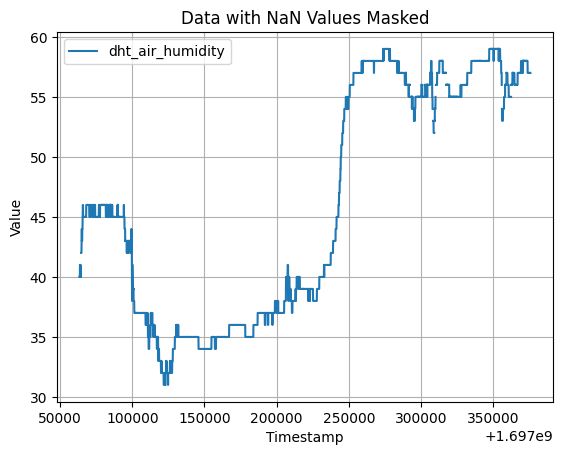

In [13]:
# for col_idx, col_name in enumerate(combined_df.columns[1:]):  # excluding 'timestamp'
#     plt.plot(combined_df['timestamp'], masked_data[:, col_idx + 1], label=col_name)
# only one column is selected for simplicity
col_name = 'dht_air_humidity'

plt.plot(combined_df['timestamp'], masked_data[:, 3 + 1], label=col_name)
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Data with NaN Values Masked')
plt.legend()
plt.grid(True)
plt.show()

### Generate missing values

Add value to missing values using interpolate

inference data appended from all columns

In [14]:
for col in combined_df.columns:
    combined_df[col] = combined_df[col].interpolate()

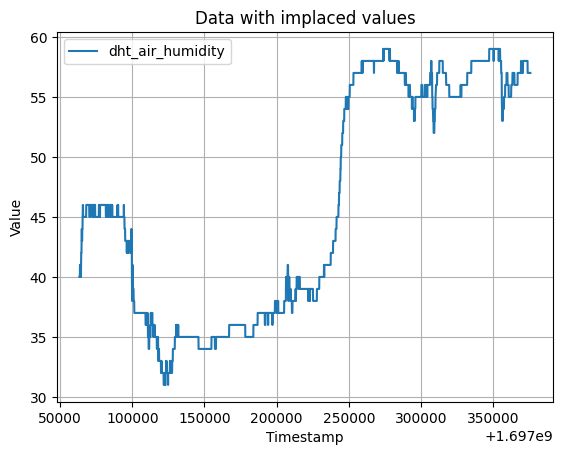

In [15]:
plt.plot(combined_df['timestamp'], combined_df[col_name], label=col_name)
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Data with implaced values')
plt.legend()
plt.grid(True)
plt.show()

## De-trend

Next step is to de-trend the values on columns which were studied on EDA. One important detail is that there is no "differencing" since non of the features has a polynomial trend

In [43]:
columns = ["light_air", "moisture_ground", "dht_air_humidity", "dht_air_temperature", "dht_ground_humidity", "dht_ground_temperature"]

In [22]:
WINDOW_SIZE = 30
plot = True

C:\Users\Bl1tty\AppData\Local\Temp\ipykernel_11396\772194006.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df[f"{col}_detrended"] = detrended_ts


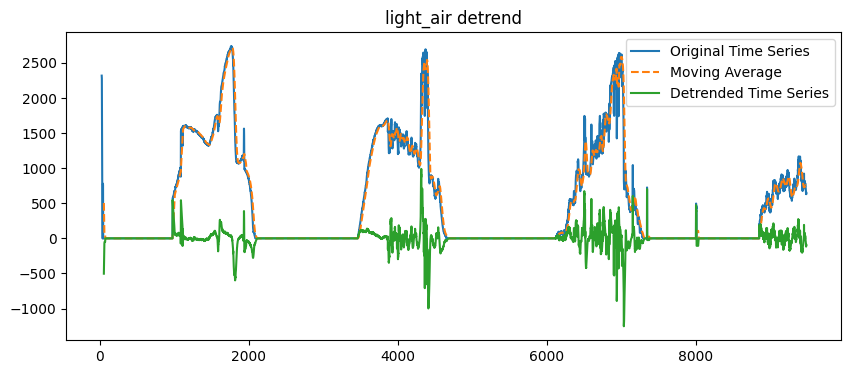

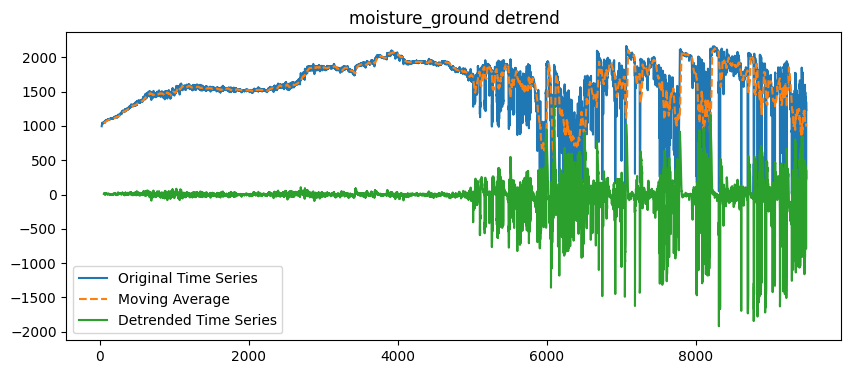

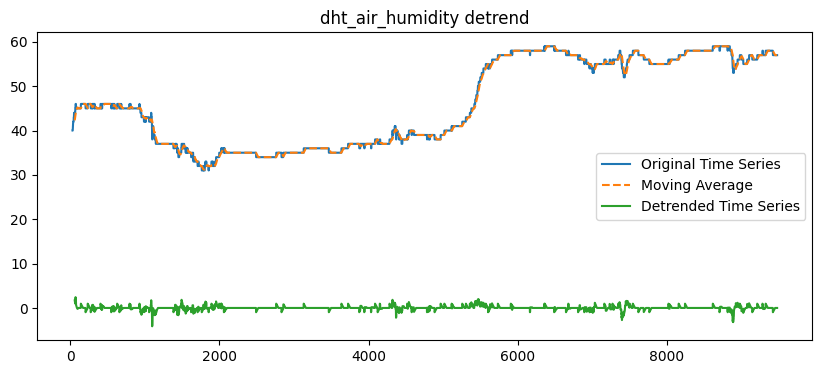

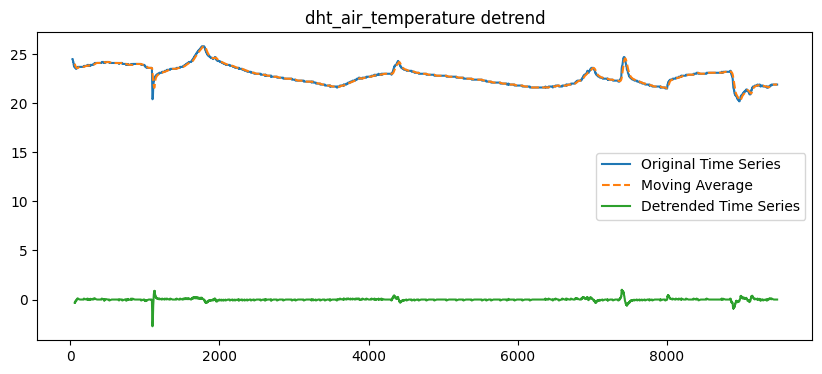

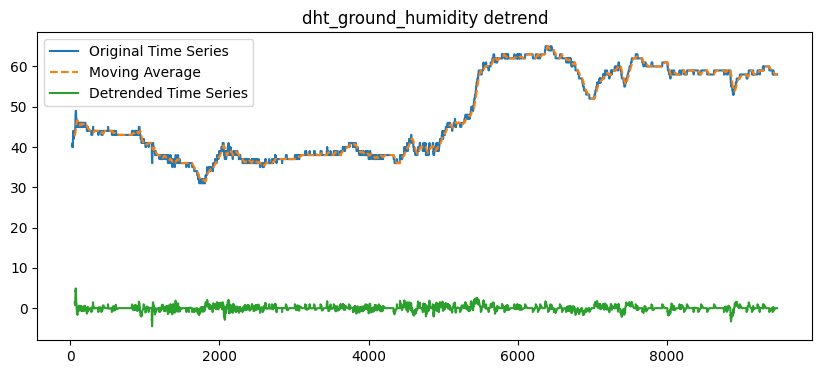

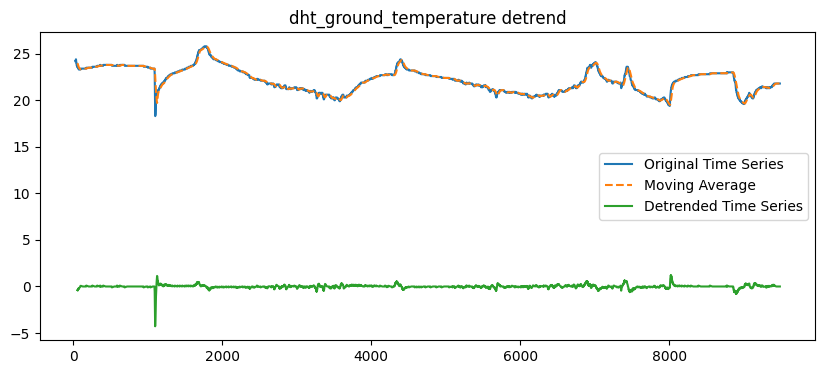

In [30]:
for col in columns:
    moving_avg = combined_df[col].rolling(window=WINDOW_SIZE).mean()
    detrended_ts = combined_df[col] - moving_avg
    combined_df[f"{col}_detrended"] = detrended_ts

    if plot:
        # Plot original and detrended time series
        plt.figure(figsize=(10, 4))
        plt.title(f"{col} detrend")
        plt.plot(combined_df[col], label='Original Time Series')
        plt.plot(moving_avg, label='Moving Average', linestyle='--')
        plt.plot(detrended_ts, label='Detrended Time Series')
        plt.legend()
        plt.show()

In [31]:
# get rid of first 30 values because no trend can be calculated thus is filled with NaN values
combined_df = combined_df.dropna()

## Scale to 0, 1

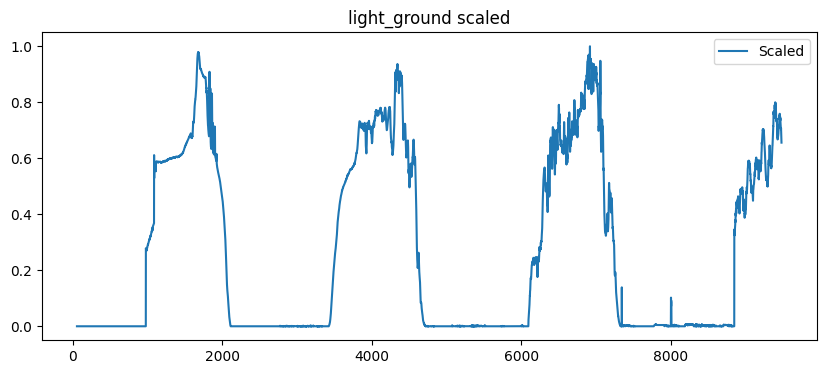

In [41]:
col = 'light_ground'
min_val = combined_df[f'{col}'].min()
max_val = combined_df[f'{col}'].max()
scaled_series = (combined_df[f'{col}'] - min_val) / (max_val - min_val)
combined_df[f'{col}_scaled'] = scaled_series

if plot:
    # Plot original and detrended time series
    plt.figure(figsize=(10, 4))
    plt.title(f"{col} scaled")
    plt.plot(scaled_series, label='Scaled')
    plt.legend()
    plt.show()

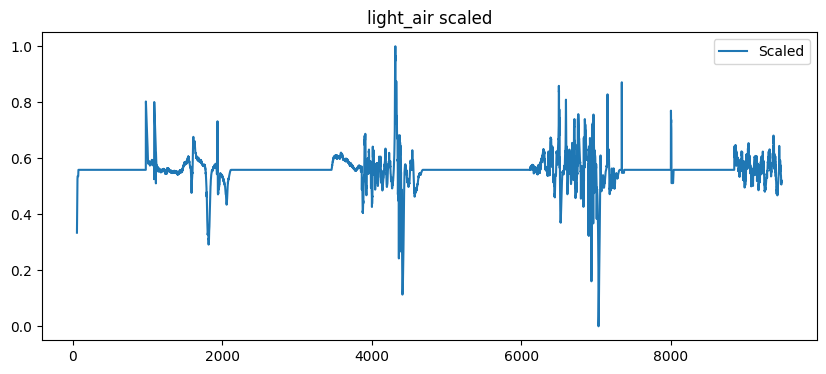

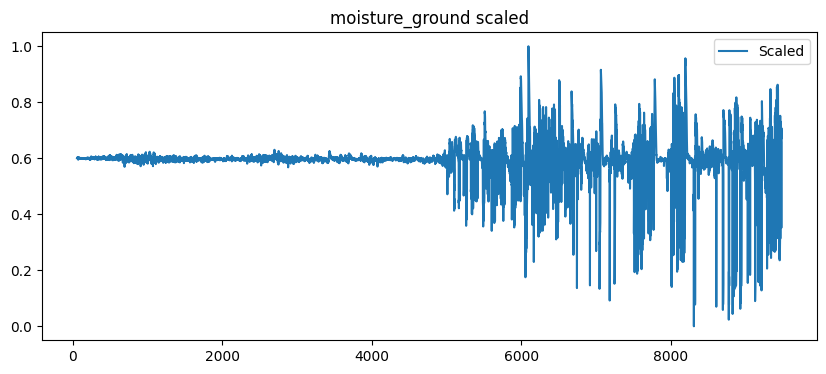

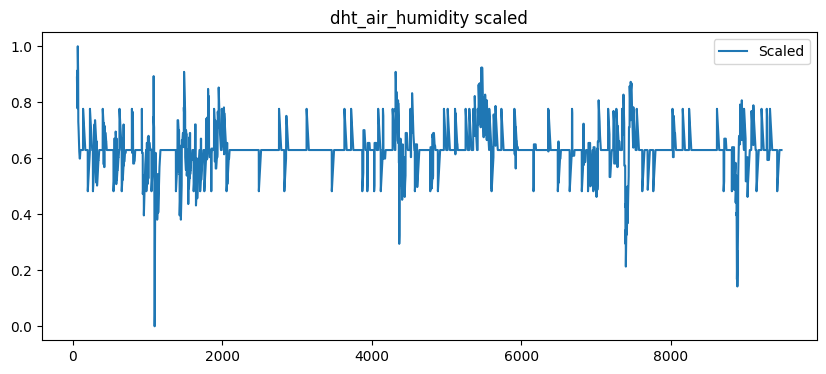

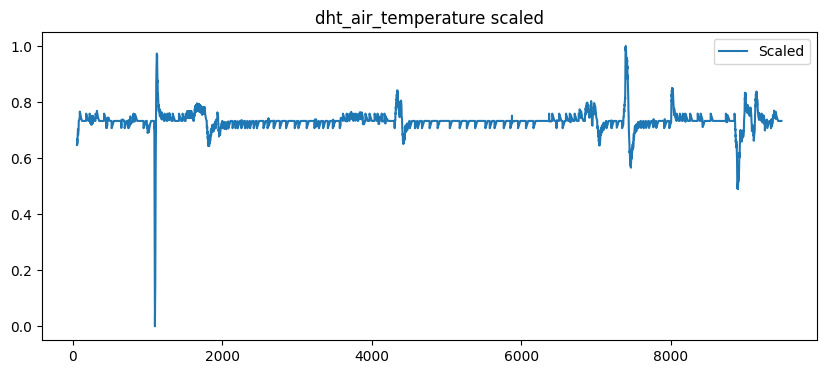

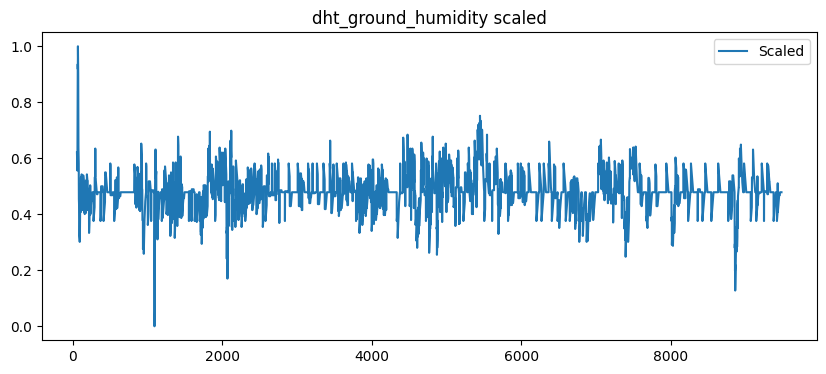

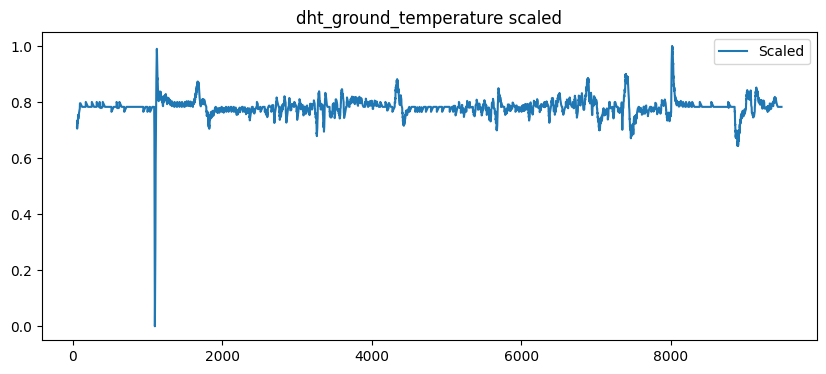

In [44]:
for col in columns:
    # scaling values
    min_val = combined_df[f'{col}_detrended'].min()
    max_val = combined_df[f'{col}_detrended'].max()
    scaled_series = (combined_df[f'{col}_detrended'] - min_val) / (max_val - min_val)
    combined_df[f'{col}_scaled'] = scaled_series

    if plot:
        # Plot original and detrended time series
        plt.figure(figsize=(10, 4))
        plt.title(f"{col} scaled")
        plt.plot(scaled_series, label='Scaled')
        plt.legend()
        plt.show()

## Export data

CSV that is used by model

In [38]:
combined_df.columns

Index(['timestamp', 'light_air', 'light_ground', 'moisture_ground',
       'dht_air_humidity', 'dht_air_temperature', 'dht_ground_humidity',
       'dht_ground_temperature', 'light_air_detrended',
       'moisture_ground_detrended', 'dht_air_humidity_detrended',
       'dht_air_temperature_detrended', 'dht_ground_humidity_detrended',
       'dht_ground_temperature_detrended', 'light_air_scaled',
       'moisture_ground_scaled', 'dht_air_humidity_scaled',
       'dht_air_temperature_scaled', 'dht_ground_humidity_scaled',
       'dht_ground_temperature_scaled'],
      dtype='object')

In [49]:
# extract columns that will be used for training
cols = ['timestamp', 'light_air_scaled', 'light_ground_scaled', 'moisture_ground_scaled',
        'dht_air_humidity_scaled', 'dht_air_temperature_scaled', 'dht_ground_humidity_scaled',
        'dht_ground_temperature_scaled']
df = combined_df[cols]
df.head()

,timestamp,light_air_scaled,light_ground_scaled,moisture_ground_scaled,dht_air_humidity_scaled,dht_air_temperature_scaled,dht_ground_humidity_scaled,dht_ground_temperature_scaled
58,1697065281,0.334191,0.0,0.600116,0.888325,0.647217,0.620567,0.712714
59,1697065315,0.368660,0.0,0.602282,0.868020,0.654399,0.606383,0.716381
60,1697065350,0.402906,0.0,0.602665,0.847716,0.661580,0.595745,0.720049
61,1697065382,0.436765,0.0,0.601297,0.827411,0.668761,0.581560,0.705990
62,1697065417,0.465946,0.0,0.601231,0.809137,0.649372,0.570213,0.710513


In [51]:
df.to_csv("../data/processed/train.csv")